In [85]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import os

In [91]:
def correction(files , num_std , max_iters):
    '''
    Corrects for the mean and standard deviation by removing files which exceed 
    {\pm num_std} standard deviations. Does so for {max_iter} iterations.
    '''
    iters = 0
    while True:
        all_regrets = []
        for f in files:
            all_regrets.append(np.load(f))
        all_cumsums = np.cumsum(all_regrets , axis = 1)
        all_means = np.mean(all_cumsums , axis = 0)
        all_std = np.std(all_cumsums , axis = 0)

        corrected_files = []

        for f in files:
            sum_regret = np.sum(np.load(f))
            z_score = (sum_regret - all_means[-1])/all_std[-1]
            if abs(z_score) < num_std:
                corrected_files.append(f)

        if len(corrected_files) == len(files):
            return corrected_files
        else:
            print(f"{len(files) - len(corrected_files)} files eliminated")
            files = corrected_files
        
        iters += 1
        if iters == max_iters:
            return corrected_files
            

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/x0/r7576wrd5w3dfxhxvxn3v81w0000gn/T/ipykernel_4627/780686105.py:2: SyntaxWarning: invalid escape sequence '\p'
  '''


In [87]:
def aggregate(folder , quantity, conditions, variables , function , add_zero = False):
    """
    aggregates files from a folder to report mean and standard deviation.

    Parameters:
        folder: name of folder
        quantity: the quantity to report the mean and std for (eg. regret/time)
        conditions: the conditions to be met by file_names to be included (starting with ! acts as a condition to not be included)
        variables: supplements the conditions by varying parameters
        function: the aggregating function (eg. sum/mean)
        add_zero: adds a zero to the beginning of the returned arrays
    """
    all_original_files = os.listdir(folder)
    subset_files = []
    for c in conditions:
        if c[0] != "!":
            subset_files = [f for f in all_original_files if c in f]
        else:
            subset_files = [f for f in all_original_files if c[1:] not in f]
        all_original_files = subset_files
    

    subset_files_per_variable = []
    for v in variables:
        subset_files_per_variable.append([f for f in all_original_files if v in f])


    final_means , final_stds = [] , []
    for list_files in subset_files_per_variable:
        all_quantity = [np.load(f"{folder}/{f}/{quantity}.npy") for f in list_files]
        all_function = function(all_quantity , axis = 1)
        final_means.append(np.mean(all_function , axis = 0))
        final_stds.append(np.std(all_function , axis = 0))

    if add_zero:
        final_means = [0] + final_means
        final_stds = [0] + final_stds

    return final_means , final_stds

### Logistic Setting

In [ ]:
import os
alg_names = ["mlogb", "ada_ofu_ecolog" , "rs_glincb" , "ofulogplus" , "rs_mnl"]
for run in range(0,10):
    print(f"\nSTARTING RUN {run} \n")
    for horizon in [1000 , 2500,5000]:
        for alg_name in alg_names:
            reward_seed = ((123 * run)%1e7) + run
            command = f"caffeinate python3 main.py  --horizon {horizon} --failure_level 0.05 --dim_arms 3 --num_arms 10 --param_norm_ub 2   --alg_name {alg_name} --reward_seed {int(reward_seed)} --num_outcomes 1"
            os.system(command)

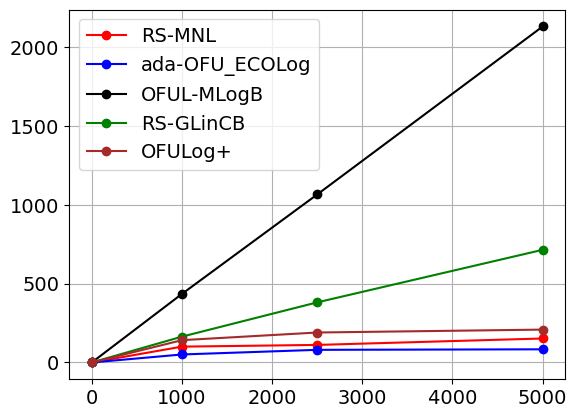

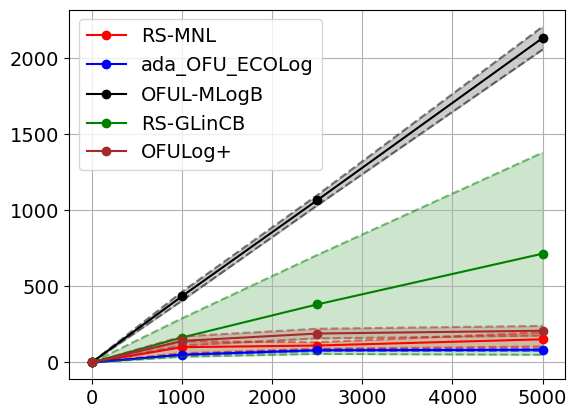

In [ ]:

horizon = [1000,2500,5000]

rs_mnl_mean , rs_mnl_std = aggregate("Results/rs_mnl" , "regret" , ["K=1"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
ada_mean , ada_std = aggregate("Results/ada_ofu_ecolog" , "regret" , ["K=1"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
mlogb_mean , mlogb_std = aggregate("Results/mlogb" , "regret" , ["K=1"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
rs_glincb_mean , rs_glincb_std = aggregate("Results/rs_glincb" , "regret" , ["K=1"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
ofulog_mean , ofulog_std = aggregate("Results/ofulogplus" , "regret" , ["K=1"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)

horizon = [0] + horizon

plt.plot(horizon , rs_mnl_mean , '-o' , color = "red" , label = "RS-MNL")
# plt.fill_between(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std), np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std), color = "red", alpha = 0.2)
# plt.plot(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)
# plt.plot(horizon , np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)


plt.plot(horizon , ada_mean , '-o' , color = "blue" , label = "ada-OFU_ECOLog")
# plt.fill_between(horizon , np.array(ada_mean) - 2*np.array(ada_std), np.array(ada_mean) + 2*np.array(ada_std), color = "blue", alpha = 0.2)
# plt.plot(horizon , np.array(ada_mean) - 2*np.array(ada_std) , '--' , color = "blue" , alpha = 0.5)
# plt.plot(horizon , np.array(ada_mean) + 2*np.array(ada_std) , '--' , color = "blue" , alpha = 0.5)


plt.plot(horizon , mlogb_mean , '-o' , color = "black" , label = "OFUL-MLogB")
# plt.fill_between(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std), np.array(mlogb_mean) + 2*np.array(mlogb_std), color = "black", alpha = 0.2)
# plt.plot(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
# plt.plot(horizon , np.array(mlogb_mean) + 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)

plt.plot(horizon , rs_glincb_mean , '-o' , color = "green" , label = "RS-GLinCB")
# plt.fill_between(horizon , np.array(rs_glincb_mean) - 2*np.array(rs_glincb_std), np.array(rs_glincb_mean) + 2*np.array(rs_glincb_std), color = "green", alpha = 0.2)
# plt.plot(horizon , np.array(rs_glincb_mean) - 2*np.array(rs_glincb_std) , '--' , color = "green" , alpha = 0.5)
# plt.plot(horizon , np.array(rs_glincb_mean) + 2*np.array(rs_glincb_std) , '--' , color = "green" , alpha = 0.5)

plt.plot(horizon , ofulog_mean , '-o' , color = "brown" , label = "OFULog+")
# plt.fill_between(horizon , np.array(ofulog_mean) - 2*np.array(ofulog_std), np.array(ofulog_mean) + 2*np.array(ofulog_std), color = "brown", alpha = 0.2)
# plt.plot(horizon , np.array(ofulog_mean) - 2*np.array(ofulog_std) , '--' , color = "brown" , alpha = 0.5)
# plt.plot(horizon , np.array(ofulog_mean) + 2*np.array(ofulog_std) , '--' , color = "brown" , alpha = 0.5)

plt.legend()
plt.grid()
plt.show()

plt.plot(horizon , rs_mnl_mean , '-o' , color = "red" , label = "RS-MNL")
plt.fill_between(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std), np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std), color = "red", alpha = 0.2)
plt.plot(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)
plt.plot(horizon , np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)

plt.plot(horizon , ada_mean , '-o' , color = "blue" , label = "ada_OFU_ECOLog")
plt.fill_between(horizon , np.array(ada_mean) - 2*np.array(ada_std), np.array(ada_mean) + 2*np.array(ada_std), color = "blue", alpha = 0.2)
plt.plot(horizon , np.array(ada_mean) - 2*np.array(ada_std) , '--' , color = "blue" , alpha = 0.5)
plt.plot(horizon , np.array(ada_mean) + 2*np.array(ada_std) , '--' , color = "blue" , alpha = 0.5)


plt.plot(horizon , mlogb_mean , '-o' , color = "black" , label = "OFUL-MLogB")
plt.fill_between(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std), np.array(mlogb_mean) + 2*np.array(mlogb_std), color = "black", alpha = 0.2)
plt.plot(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
plt.plot(horizon , np.array(mlogb_mean) + 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)

plt.plot(horizon , rs_glincb_mean , '-o' , color = "green" , label = "RS-GLinCB")
plt.fill_between(horizon , np.array(rs_glincb_mean) - 2*np.array(rs_glincb_std), np.array(rs_glincb_mean) + 2*np.array(rs_glincb_std), color = "green", alpha = 0.2)
plt.plot(horizon , np.array(rs_glincb_mean) - 2*np.array(rs_glincb_std) , '--' , color = "green" , alpha = 0.5)
plt.plot(horizon , np.array(rs_glincb_mean) + 2*np.array(rs_glincb_std) , '--' , color = "green" , alpha = 0.5)

plt.plot(horizon , ofulog_mean , '-o' , color = "brown" , label = "OFULog+")
plt.fill_between(horizon , np.array(ofulog_mean) - 2*np.array(ofulog_std), np.array(ofulog_mean) + 2*np.array(ofulog_std), color = "brown", alpha = 0.2)
plt.plot(horizon , np.array(ofulog_mean) - 2*np.array(ofulog_std) , '--' , color = "brown" , alpha = 0.5)
plt.plot(horizon , np.array(ofulog_mean) + 2*np.array(ofulog_std) , '--' , color = "brown" , alpha = 0.5)

plt.legend()
plt.grid()
plt.show()



### Number of Outcomes = 3

In [ ]:
import os
alg_names = ["mlogb" , "rs_mnl"]
for run in range(0,20):
    print(f"\nSTARTING RUN {run} \n")
    for horizon in [1000 , 2500,5000]:
        for alg_name in alg_names:
            reward_seed = ((123 * run)%1e7) + run
            command = f"caffeinate python3 main.py  --horizon {horizon} --failure_level 0.05 --dim_arms 3 --num_arms 10 --param_norm_ub 2   --alg_name {alg_name} --reward_seed {int(reward_seed)} --num_outcomes 3 "
            os.system(command)

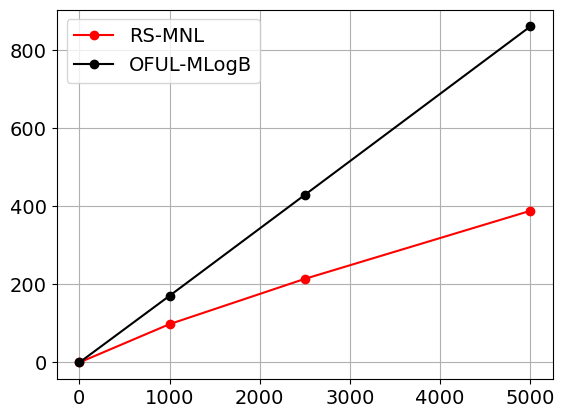

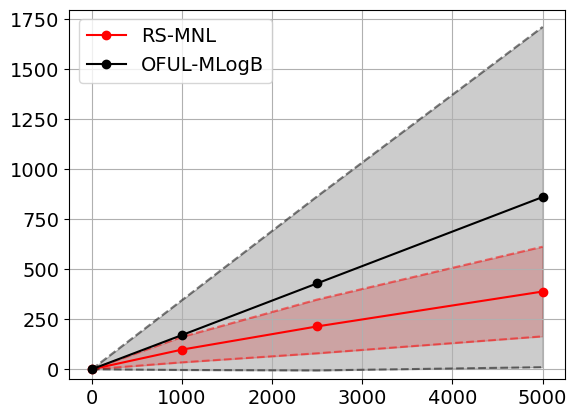

In [ ]:
horizon = [1000,2500,5000]

rs_mnl_mean , rs_mnl_std = aggregate("Results/rs_mnl" , "regret" , ["K=3"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
mlogb_mean , mlogb_std = aggregate("Results/mlogb" , "regret" , ["K=3"] , [f"T={h}_" for h in horizon] , np.sum , add_zero = True)
horizon = [0] + horizon

plt.plot(horizon , rs_mnl_mean , '-o' , color = "red" , label = "RS-MNL")
# plt.fill_between(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std), np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std), color = "red", alpha = 0.2)
# plt.plot(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)
# plt.plot(horizon , np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)


plt.plot(horizon , mlogb_mean , '-o' , color = "black" , label = "OFUL-MLogB")
# plt.fill_between(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std), np.array(mlogb_mean) + 2*np.array(mlogb_std), color = "black", alpha = 0.2)
# plt.plot(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
# plt.plot(horizon , np.array(mlogb_mean) + 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
plt.legend()
plt.grid()
plt.show()

plt.plot(horizon , rs_mnl_mean , '-o' , color = "red" , label = "RS-MNL")
plt.fill_between(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std), np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std), color = "red", alpha = 0.2)
plt.plot(horizon , np.array(rs_mnl_mean) - 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)
plt.plot(horizon , np.array(rs_mnl_mean) + 2*np.array(rs_mnl_std) , '--' , color = "red" , alpha = 0.5)


plt.plot(horizon , mlogb_mean , '-o' , color = "black" , label = "OFUL-MLogB")
plt.fill_between(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std), np.array(mlogb_mean) + 2*np.array(mlogb_std), color = "black", alpha = 0.2)
plt.plot(horizon , np.array(mlogb_mean) - 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
plt.plot(horizon , np.array(mlogb_mean) + 2*np.array(mlogb_std) , '--' , color = "black" , alpha = 0.5)
plt.legend()
plt.grid()
plt.ylim(-50,)
plt.show()

### Number of switches as a function of time

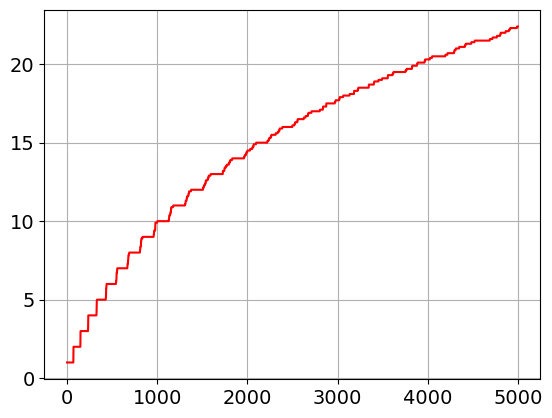

In [ ]:
# switches
folder = "Results/rs_mnl"
switches_array = []
for file_folder in os.listdir(folder):
    if "K=3" in file_folder and "T=5000_" in file_folder:
        switches_array.append(np.load(f"{folder}/{file_folder}/switches.npy"))

switches_mean = np.mean(switches_array , axis = 0)
switches_std = np.std(switches_array , axis = 0)

plt.plot(switches_mean , color = "red")
# plt.fill_between([_ for _ in range(len(switches_mean))] , switches_mean - 2*switches_std , switches_mean + 2*switches_std , alpha = 0.2 , color = "red")
plt.grid()
plt.show()